In [47]:
# Install dependencies
# !pip install sentence-transformers umap-learn bertopic torch scikit-learn pandas


In [48]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [49]:
import os
os.getcwd()
os.chdir(r"C:\Users\66738\OneDrive - Bain\Documents\Personal Docs\Agents - AI\DNN_Clustering\Personal_projects")


In [50]:
df = pd.read_csv('..//data/Reviews.csv')

In [51]:
df.shape

(568454, 10)

In [52]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [53]:
df = df[['Text']].dropna().sample(250000, random_state=42)  # subset for speed
print(df.head())

                                                     Text
165256  Having tried a couple of other brands of glute...
231465  My cat loves these treats. If ever I can't fin...
427827  A little less than I expected.  It tends to ha...
433954  First there was Frosted Mini-Wheats, in origin...
70260   and I want to congratulate the graphic artist ...


In [54]:
folder = r"C:\Users\66738\OneDrive - Bain\Documents\Personal Docs\Agents - AI\all-MiniLM-L6-v2"

In [55]:
model = SentenceTransformer(
    r"C:\Users\66738\OneDrive - Bain\Documents\Personal Docs\Agents - AI\all-MiniLM-L6-v2"
)
print("Model loaded:", model)

Model loaded: SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [56]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [57]:
# Load pre-trained Sentence-BERT
embeddings = model.encode(df['Text'].tolist(), show_progress_bar=True)

print("Embedding shape:", embeddings.shape)  # (20000, 384)

Batches: 100%|██████████| 7813/7813 [1:54:32<00:00,  1.14it/s]  


Embedding shape: (250000, 384)


## If you had 20,000 reviews, the final tensor shape = (20000, 384)

## 20000 = number of rows = number of reviews.

## 384 = number of columns = dimension of each embedding vector.

## So yes:

## Each review/comment is embedded separately into its own 384-dim vector.

## Batch size just controls how many reviews go through the model at the same time for efficiency.

In [58]:
class Autoencoder(nn.Module): #nn.Module is the base class for all neural network models and layers.
    '''Every model you build in PyTorch must inherit from nn.Module.
        It provides the framework that allows PyTorch to:
        Register layers and parameters
        Track them for training
        Save/load models easily
        Move models to GPU/CPU (.to(device), .cuda()'''
    def __init__(self, input_dim=384, hidden1=128, hidden2=64, latent_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

# Convert embeddings to torch tensors
X = torch.tensor(embeddings, dtype=torch.float32)
dataset = TensorDataset(X, X)
'''TensorDataset creates a dataset where each sample is a pair (input, target).
Here you pass (X, X) because in an autoencoder:
Input = the embedding itself.
Target = also the embedding (since we want to reconstruct the input).'''
dataloader = DataLoader(dataset, batch_size=256, shuffle=True) #256 reviews × 384 features each.

### Encoder-Decoder explain: 
		1. Encoder ○ Learns how to compress high-dimensional input (384-d SBERT embedding) → lower-dimensional latent space (e.g., 32-d).
		○ Think of it like extracting the essence of the input — only the most important information.
	2. Decoder
		○ Learns how to reconstruct the original input from the compressed latent vector.
		○ Without the decoder, there’s no “pressure” on the encoder to preserve useful info.
		○ The reconstruction task is what forces the encoder to learn meaningful features instead of just random numbers.
    👉 So the encoder+decoder pair is a training trick:
        • The encoder by itself can’t be trained (no labels!).
        • By adding a decoder and asking the model to reconstruct the input, we create a self-supervised learning task.
        • The reconstruction loss (MSE between input & output) guides both encoder and decoder during training.

    🔎 Is This Just Forward/Backward Propagation?
    The network itself = encoder + decoder = one complete neural network.

In [59]:
X

tensor([[-0.0856, -0.0820,  0.0190,  ..., -0.0840, -0.0361,  0.0294],
        [ 0.0673, -0.0611,  0.0285,  ...,  0.0393,  0.0469,  0.0259],
        [ 0.0177, -0.0267,  0.0264,  ..., -0.0778, -0.0225,  0.0256],
        ...,
        [-0.0376, -0.0265,  0.1125,  ...,  0.0059,  0.0881,  0.0078],
        [-0.0129, -0.0897,  0.0680,  ..., -0.1357,  0.0185, -0.0714],
        [-0.0553, -0.0481, -0.0287,  ...,  0.0391, -0.0206, -0.0127]])

In [60]:
first_batch = next(iter(dataloader))
print(first_batch)

[tensor([[-0.0937, -0.1043,  0.0141,  ..., -0.0549,  0.0226, -0.1312],
        [ 0.0011, -0.0669,  0.0024,  ...,  0.0227,  0.0610, -0.0593],
        [-0.0138, -0.1244,  0.0477,  ...,  0.0342,  0.0129, -0.0109],
        ...,
        [ 0.0128,  0.0097,  0.0683,  ..., -0.0200,  0.0512,  0.0489],
        [-0.1161, -0.0365,  0.0012,  ...,  0.0662, -0.0416, -0.0165],
        [-0.0687, -0.0654,  0.0062,  ..., -0.0241,  0.0244, -0.0369]]), tensor([[-0.0937, -0.1043,  0.0141,  ..., -0.0549,  0.0226, -0.1312],
        [ 0.0011, -0.0669,  0.0024,  ...,  0.0227,  0.0610, -0.0593],
        [-0.0138, -0.1244,  0.0477,  ...,  0.0342,  0.0129, -0.0109],
        ...,
        [ 0.0128,  0.0097,  0.0683,  ..., -0.0200,  0.0512,  0.0489],
        [-0.1161, -0.0365,  0.0012,  ...,  0.0662, -0.0416, -0.0165],
        [-0.0687, -0.0654,  0.0062,  ..., -0.0241,  0.0244, -0.0369]])]


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_dim=embeddings.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
model.train()
losses = []
for epoch in range(epochs):
    total_loss = 0
    for batch_x, _ in dataloader: #Most datasets in PyTorch (e.g., torchvision.datasets.MNIST, CIFAR10, etc.) return each sample as a tuple
        #In your code, you only care about the input data (batch_x) and don’t need the labels so _ mentioned in loop
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        reconstructed, _ = model(batch_x)
        loss = criterion(reconstructed, batch_x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")


Epoch 1, Loss: 0.0013
Epoch 1, Loss: 0.0013
Epoch 2, Loss: 0.0010
Epoch 2, Loss: 0.0010
Epoch 3, Loss: 0.0009
Epoch 3, Loss: 0.0009
Epoch 4, Loss: 0.0009
Epoch 4, Loss: 0.0009
Epoch 5, Loss: 0.0009
Epoch 5, Loss: 0.0009
Epoch 6, Loss: 0.0009
Epoch 6, Loss: 0.0009
Epoch 7, Loss: 0.0009
Epoch 7, Loss: 0.0009
Epoch 8, Loss: 0.0009
Epoch 8, Loss: 0.0009
Epoch 9, Loss: 0.0009
Epoch 9, Loss: 0.0009
Epoch 10, Loss: 0.0009
Epoch 10, Loss: 0.0009
Epoch 11, Loss: 0.0009
Epoch 11, Loss: 0.0009
Epoch 12, Loss: 0.0009
Epoch 12, Loss: 0.0009
Epoch 13, Loss: 0.0009
Epoch 13, Loss: 0.0009
Epoch 14, Loss: 0.0009
Epoch 14, Loss: 0.0009
Epoch 15, Loss: 0.0009
Epoch 15, Loss: 0.0009
Epoch 16, Loss: 0.0009
Epoch 16, Loss: 0.0009
Epoch 17, Loss: 0.0009
Epoch 17, Loss: 0.0009
Epoch 18, Loss: 0.0009
Epoch 18, Loss: 0.0009
Epoch 19, Loss: 0.0009
Epoch 19, Loss: 0.0009
Epoch 20, Loss: 0.0009
Epoch 20, Loss: 0.0009


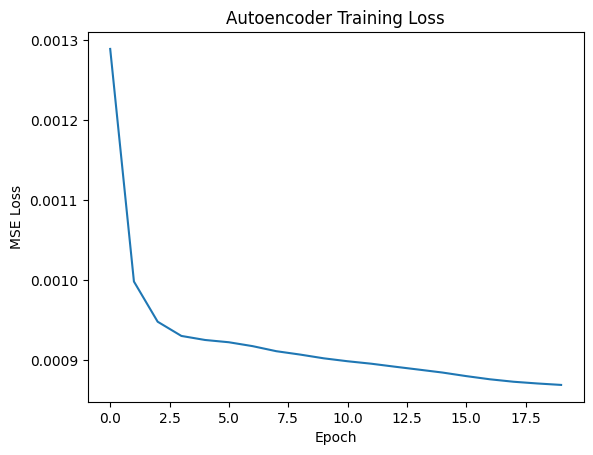

In [62]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.show()


In [63]:
model.eval()
with torch.no_grad():
    _, latent_embeddings = model(X.to(device))
latent_embeddings = latent_embeddings.cpu().numpy()
print("Latent shape:", latent_embeddings.shape)  # (20000, 32)


Latent shape: (250000, 32)


In [64]:
k = 8  # number of clusters (tune with silhouette)
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(latent_embeddings)

score = silhouette_score(latent_embeddings, labels)
print("Silhouette Score:", score)


Silhouette Score: 0.10099092125892639


In [65]:
df['Cluster'] = labels
for i in range(k):
    sample_reviews = df[df['Cluster'] == i]['Text'].sample(3, random_state=42).tolist()
    print(f"\nCluster {i} sample reviews:")
    for r in sample_reviews:
        print("-", r[:200], "...")



Cluster 0 sample reviews:
- My doggie love her birthday bones. She has a sensitive stomach and the bones didn't make her sick. Thank you! ...
- I love it because it flys so easily and doesn't hurt the dog if it hits her nor when she catches it.  However, she prefers the plastic glow in the dark disc I bought. ...
- I have 2 Jack Russells and they love these bones...they are not small but not too big for them :-) they cant get enough and they last long and they dont smell after a few uses like other ones. ...

Cluster 1 sample reviews:
- I love these bars. What more can I say? They contain less sugar than a lot of other bars and still taste pretty good. ...
- I LOVE the Blue Diamond Butter Toffee and The Chocolate.  This is my first try with the Cinnamon and they are fabulous!  I eat and live low carb and eat a lot of nuts...the flavored Blue Diamond Almon ...
- I am a jerky snob as most are either too high in fat or have way too much seasoning on them. The natural flavor of Ostrim is 

In [66]:
# pip install openai
import openai

openai.api_key = "YOUR_API_KEY"

def generate_persona(summary_text):
    prompt = f"""
    You are a business analyst. Here is a cluster of customer feedback:
    {summary_text}

    1. Give this cluster a persona name.
    2. Describe the customer type in 2-3 lines.
    3. Suggest 1 business action for this segment.
    """
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=200
    )
    return response['choices'][0]['text'].strip()

# Example: pass representative reviews of a cluster
sample_text = " ".join(df[df['Cluster'] == 0]['Text'].sample(5).tolist())
print(generate_persona(sample_text))


APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742
